In [1]:
import numpy as np
from DSSStartup import DSSStartup
from setInfo import *
from getInfo import *
import matplotlib.pyplot as plt
from math import tan,acos
import copy
import pandas as pd
import time
from replay_buffer import ReplayBuffer
import numpy as np
#######################################################
#######################################################
###Global variable initialization and error checking###
#######################################################
#######################################################
Sbase=1
LoadScalingFactor = 1.5
GenerationScalingFactor = 5 
SlackBusVoltage = 1.04 
NoiseMultiplyer= 0

#Set simulation analysis period - the simulation is from StartTime to EndTime
StartTime = 42900
EndTime = 44000
EndTime += 1 # creating a list, last element does not count, so we increase EndTime by 1
#Set hack parameters
TimeStepOfHack = 300
PercentHacked = np.array([0,0,0,0,0, 0,0,.5,0,0,.5,.5,.5,.5,.5,0,0,.5, 0,0,0,0,0,0,0,0,0,0,0,0,0])
#PercentHacked = np.array([0,0,0,0,0, .1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1, 0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set initial VBP parameters for uncompromised inverters
VQ_start = 1.01
VQ_end = 1.03
VP_start = 1.03
VP_end = 1.05

#Set delays for each node

Delay_VoltageSampling = np.array([0,0,0,0,0, 10,10,10,10,10,10,10,10,10,10,10,10,10, 0,0,0,0,0,0,0,0,0,0,0,0,0]) 
Delay_VBPCurveShift =   np.array([0,0,0,0,0, 60,60,60,60,60,60,60,60,60,60,60,60,60, 0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set observer voltage threshold
ThreshHold_vqvp = 0.25
power_factor=0.9
pf_converted=tan(acos(power_factor))
Number_of_Inverters = 13 #even feeder is 34Bus, we only have 13 inverters


#Error checking of the global variable -- TODO: add error handling here!
if EndTime < StartTime or EndTime < 0 or StartTime < 0:
    print('Setup Simulation Times Appropriately.')
if NoiseMultiplyer < 0:
    print('Setup Noise Multiplyer Correctly.')
    
DSSStart = DSSStartup()
DSSText =DSSStart['dsstext']
DSSSolution = DSSStart['dsssolution']
DSSCircuit = DSSStart['dsscircuit']
DSSObj = DSSStart['dssobj']
DSSMon = DSSCircuit.Monitors
DSSText.command = 'Compile C:\\feeders\\feeder34_B_NR\\feeder34_B_NR.dss'
DSSSolution.Solve()
if not DSSSolution.Converged:
    print('Initial Solution Not Converged. Check Model for Convergence')
else:
    print('Initial Model Converged. Proceeding to Next Step.')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    DSSMon.ResetAll
    setSolutionParams(DSSObj,'daily',1,1,'off',1000000,30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=DSSCircuit.Loads.Count
    AllLoadNames=DSSCircuit.Loads.AllNames
    print('OpenDSS Model Compliation Done.')

#######################################################
#######################################################
####         Load data from file                    ###
#######################################################
#######################################################

#Retrieving the data from the load profile
TimeResolutionOfData=10 #resolution in minute
#Get the data from the Testpvnum folder
#Provide Your Directory - move testpvnum10 from github to drive C: 
FileDirectoryBase ='C:\\feeders\\testpvnum10\\';
QSTS_Time = list(range(1441)) #This can be changed based on the available data - for example, 1440 timesteps
QSTS_Data = np.zeros((len(QSTS_Time) ,4,TotalLoads)) #4 columns as there are four columns of data available in the .mat file

for node in range(TotalLoads):
    #This is created manually according to the naming of the folder
    FileDirectoryExtension = 'node_' + str(node+1) + '_pv_' +str(TimeResolutionOfData) + '_minute.csv'
    #The total file directory
    FileName = FileDirectoryBase + FileDirectoryExtension
    #Load the file
    MatFile = np.genfromtxt(FileName, delimiter=',')    
    QSTS_Data[:,:,node] = MatFile #Putting the loads to appropriate nodes according to the loadlist
    
Generation = QSTS_Data[:,1,:]*GenerationScalingFactor #solar generation
Load = QSTS_Data[:,3,:]*LoadScalingFactor #load demand
Generation = np.squeeze(Generation)/Sbase  #To convert to per unit, it should not be multiplied by 100
Load = np.squeeze(Load)/Sbase
print('Reading Data for Pecan Street is done.')

############################################################
############################################################
#### Interpolate to change data from minutes to seconds ####
############################################################
############################################################

from scipy.interpolate import interp1d

print('Starting Interpolation...')

#interpolation for the whole period...
Time = list(range(StartTime,EndTime))
TotalTimeSteps = len(Time)
LoadSeconds = np.empty([3600*24, TotalLoads])
GenerationSeconds = np.empty([3600*24, TotalLoads])
# Interpolate to get minutes to seconds
for node in range(TotalLoads): # i is node
    t_seconds = np.linspace(1,len(Load[:,node]), int(3600*24/1))
    f = interp1d(range(len(Load[:,node])), Load[:,node], kind='cubic', fill_value="extrapolate")
    LoadSeconds[:,node] = f(t_seconds) #spline method in matlab equal to Cubic Spline -> cubic
    
    f = interp1d(range(len(Generation[:,node])), Generation[:,node], kind='cubic', fill_value="extrapolate")
    GenerationSeconds[:,node]= f(t_seconds)

# Initialization
# then we take out only the window we want...
LoadSeconds = LoadSeconds[StartTime:EndTime,:]
GenerationSeconds = GenerationSeconds[StartTime:EndTime,:]
Load = LoadSeconds
Generation = GenerationSeconds
Origin_Load = LoadSeconds
Origin_Generation = GenerationSeconds

Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
Reading Data for Pecan Street is done.
Starting Interpolation...


In [2]:
############################################################
############################################################
#### Function for simulation################################
############################################################
############################################################

def inverter_qp_injection(counter, Vk, Vkm1, gammakm1, solar_irr, VBP, Sbar, dv, T=1, lpf=1):
    pk = 0
    qk = 0
    c = 0
    q_avail = 0

    solar_range = 5

    Vmagk = abs(Vk)
    Vmagkm1 = abs(Vkm1)
    gammakcalc = (T*lpf*(Vmagk + Vmagkm1) - (T*lpf - 2)*gammakm1)/(2 + T*lpf)

    if counter % dv == 0:
        gammakused = gammakcalc
    else :
        gammakused = gammakm1

    if solar_irr < solar_range:
        pk = 0
        qk = 0
    elif solar_irr >= solar_range:
        if gammakused <= VBP[2]:
            pk = -solar_irr
            q_avail = (Sbar**2 - pk**2)**(1/2)
            if gammakused <= VBP[0]:
                qk = 0
            elif gammakused > VBP[0] and gammakused <= VBP[1]:
                c = q_avail/(VBP[1] - VBP[0])
                qk = c*(gammakused - VBP[0])
            else:
                qk = q_avail
        elif gammakused > VBP[2] and gammakused < VBP[3]:
            d = -solar_irr/(VBP[3] - VBP[2])
            pk = -(d*(gammakused - VBP[2]) + solar_irr)
            qk = (Sbar**2 - pk**2)**(1/2)
        elif gammakused >= VBP[3]:
            qk = Sbar
            pk = 0
    return qk,pk, gammakused
    
def voltage_observer(vk, vkm1, psikm1, epsilonkm1, ykm1, f_hp=1, f_lp=0.1, gain=1e5, T=1):
    Vmagk = abs(vk)
    Vmagkm1 = abs(vkm1)
    psik = (Vmagk - Vmagkm1 - (f_hp*T/2-1)*psikm1)/(1+f_hp*T/2)
    epsilonk = gain*(psik**2)
    yk = (T*f_lp*(epsilonk + epsilonkm1) - (T*f_lp - 2)*ykm1)/(2 + T*f_lp)
    return yk, psik, epsilonk

def adaptive_control(delay, vk, vkmdelay, ukmdelay, thresh, yk):
    if (yk > thresh):
        uk = delay/2*k * ( vk**2 + vkmdelay**2 ) + ukmdelay
    else:
        uk = ukmdelay
    return uk

In [3]:
#support function
def processing_state(V, G, L):
    state = np.array([V, G, L]).T
    result = np.zeros((60,3))
    result[:state.shape[0],:state.shape[1]] = state #padding with zeros
    state = result.copy()
    return state

In [4]:
#this is the agent
import tensorflow as tf
EPS = 1e-6

def build_graph(inputs, layer_sizes, non_linearlayer=False):
    if type(inputs) is tf.Tensor:
        inputs = [inputs]
    
    with tf.variable_scope('layer0'):
        state = inputs[0]
        gru_cell = tf.contrib.rnn.GRUCell(num_units=32)
        outputs, states = tf.nn.dynamic_rnn(gru_cell, state, dtype=tf.float32)
        state0 = tf.layers.dense(states, 30)
        if len(inputs) != 1:
            action = inputs[1]
            action0 = tf.layers.dense(action, 30)
            layer = action0 + state0
        else: 
            layer = state0
        layer = tf.nn.relu(layer)
    
    for i_layer, size in enumerate(layer_sizes, 1):
        with tf.variable_scope('layer{0}'.format(i_layer)):
            layer = tf.layers.dense(layer, size)
            if i_layer < len(layer_sizes) - 1:
                layer = tf.nn.relu(layer)
    
    if non_linearlayer==True:
        layer = tf.nn.tanh(layer)
    
    return layer

class NNFunction():
    def __init__(self, name, input_pls, hidden_layer_sizes):
        self._name = name
        self._input_pls = input_pls
        if name != 'policy':
            self._layer_sizes = list(hidden_layer_sizes) + [1]
        else:
            self._layer_sizes = list(hidden_layer_sizes) + [4]
        self._output_t = self.get_output_for(*self._input_pls)
    def get_output_for(self, *inputs, reuse=False):
        with tf.variable_scope(self._name, reuse=reuse):
            value_t = build_graph(inputs=inputs, layer_sizes=self._layer_sizes)
        return value_t
    
    def get_params_internal(self):

        scope = tf.get_variable_scope().name
        scope += '/' + self._name + '/' if len(scope) else self._name + '/'
        return tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope
        )

class NNQFunction(NNFunction):
    def __init__(self, hidden_layer_sizes=(30,30), name='qf'):
        self._Da = 4
        self._Do = [60,3]
        self._obs_pl = tf.placeholder(tf.float32, shape=[None]+ self._Do, name='observation')
        self._action_pl = tf.placeholder(tf.float32, shape=[None, self._Da], name='action')
        super(NNQFunction, self).__init__(name, (self._obs_pl, self._action_pl), hidden_layer_sizes)

#############################################################        
    
class Policy(NNFunction):
    def __init__(self, hidden_layer_sizes=(30,30), reparameterize=False, name='policy', squash=True):
        self._name = name
        self._Do = [60,3]
        self._Da = 4
        self._obs_pl = tf.placeholder(tf.float32, shape=[None] + self._Do, name='observation')
        self._layer_sizes = hidden_layer_sizes
        super(Policy, self).__init__(name, (self._obs_pl,), hidden_layer_sizes)
        
    def actions_for(self, observations, reuse=tf.AUTO_REUSE):
        name = self._name
        with tf.variable_scope(name, reuse=reuse):
            actions = build_graph(inputs=observations, layer_sizes=self._layer_sizes, non_linearlayer=True)        
        return actions    
    
    def get_params_internal(self):

        scope = tf.get_variable_scope().name
        scope += '/' + self._name + '/' if len(scope) else self._name + '/'
        return tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope
        )
    
    def _squash_correction(self, actions):
        if not self._squash: return 0
        return tf.reduce_sum(tf.log(1 - tf.tanh(actions) ** 2 + EPS), axis=1)
    
    def name(self):
        return self._name

class agent():
    def __init__(self, sess, observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph, name='agent'):
        self._observations_ph = observations_ph
        self._next_observations_ph = next_observations_ph
        self._rewards_ph = rewards_ph
        self._actions_ph= actions_ph
        self._terminals_ph = terminals_ph
        
        self._discount = 0.99
        self._tau = 0.01
        
        self._qf_lr = 0.1
        self._vf_lr = 0.1
        self._policy_lr = 0.01
        self._action_prior = 'Normal'
        self._reparameterize = False
        self._sess = sess
        self._training_ops = []
        
        with tf.variable_scope(name):
            self._qf = NNQFunction((30,30), 'qf')
            self._policy = Policy(hidden_layer_sizes=(30,30))
            self._init_critic_update()
            self._init_actor_update()
            self._init_target_ops()
            
        uninit_vars = []
        for var in tf.global_variables():
            try:
                self._sess.run(var)
            except tf.errors.FailedPreconditionError:
                uninit_vars.append(var)
        self._sess.run(tf.variables_initializer(uninit_vars))
        
        self._init_training()
        
    def _init_critic_update(self):
        self._qf_t = self._qf.get_output_for(self._observations_ph, self._actions_ph, reuse=True)
        
        with tf.variable_scope('target_policy'):
            actions = self._policy.actions_for(self._next_observations_ph)
            self._policy_target_params = self._policy.get_params_internal()
        
        with tf.variable_scope('target_qf'):
            self._qf_t_next = self._qf.get_output_for(self._next_observations_ph, actions)        
            self._qf_target_params = self._qf.get_params_internal()
        ys = tf.stop_gradient(
            self._rewards_ph +
            (1 - self._terminals_ph) * self._discount * self._qf_t_next)  
        
        self._td_loss_t = 0.5 * tf.reduce_mean((ys - self._qf_t)**2)
        qf_train_op = tf.train.AdamOptimizer(self._qf_lr).minimize(
            loss=self._td_loss_t,
            var_list=self._qf.get_params_internal()
        )
        self._training_ops.append(qf_train_op)
        
    def _init_actor_update(self):
        self._action = self._policy.actions_for(self._observations_ph, reuse=True)
        self._policy_params = self._policy.get_params_internal()
        self._qf_t = self._qf.get_output_for(self._observations_ph, self._actions_ph, reuse=True)
        self._qf_params = self._qf.get_params_internal()
        
        q_grads = tf.negative(tf.gradients(self._qf_t, self._actions_ph))
        grads = tf.gradients(self._action, self._policy_params, q_grads)
        
        grads = list(map(lambda x: tf.div(x, 30), grads))
        policy_train_op = tf.train.AdamOptimizer(self._policy_lr).apply_gradients(zip(grads, self._policy.get_params_internal()))
        self._training_ops.append(policy_train_op)        
        
    def _init_target_ops(self):
        """Create tensorflow operations for updating target value function."""

        source_params = self._qf_params
        target_params = self._qf_target_params
        
        self._target_ops_qf = [
            tf.assign(target, (1 - self._tau) * target + self._tau * source)
            for target, source in zip(target_params, source_params)
        ]
        
        source_params_p = self._policy_params
        target_params_p = self._policy_target_params

        self._target_ops_p = [
            tf.assign(target, (1 - self._tau) * target + self._tau * source)
            for target, source in zip(target_params_p, source_params_p)
        ]

    def _init_training(self):
        self._sess.run(self._target_ops_qf)
        self._sess.run(self._target_ops_p)

    def do_training(self, batch):
        """Runs the operations for updating training and target ops."""

        feed_dict = self._get_feed_dict(batch)
        self._sess.run(self._training_ops[0], feed_dict)
        self._sess.run(self._training_ops[1], feed_dict)
        self._sess.run(self._target_ops_qf)
        self._sess.run(self._target_ops_p)

    def _get_feed_dict(self, batch):
        """Construct TensorFlow feed_dict from sample batch."""

        feed_dict = {
            self._observations_ph: batch['observations'],
            self._actions_ph: batch['actions'],
            self._next_observations_ph: batch['next_observations'],
            self._rewards_ph: batch['rewards'],
            self._terminals_ph: batch['terminals'],
        }
        return feed_dict
   
    def action_respond(self, obs):
        action = self._action
        a = self._sess.run([action], feed_dict={observations_ph: obs})[0][0]
        return a
    
def init_placeholder():
    observations_ph = tf.placeholder(tf.float32, shape=(None, 60, 3), name='observation')
    next_observations_ph = tf.placeholder(tf.float32, shape=(None, 60, 3), name='next_observation')
    rewards_ph = tf.placeholder(tf.float32, shape=(None, 1), name='reward')
    actions_ph = tf.placeholder(tf.float32, shape=(None, 4), name='action')
    terminals_ph = tf.placeholder(tf.float32, shape=(None, 1), name='terminal')
    return observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph

D:\Apps\Anacoda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph = init_placeholder()
sess = tf.Session()
agent = agent(sess, observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph)

In [ ]:
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.005, theta=.1, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)
    

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.


D:\Apps\Anacoda3\lib\site-packages\ipykernel_launcher.py:256: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


-164441.33013041803
--- 61.653472900390625 seconds ---


D:\Apps\Anacoda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


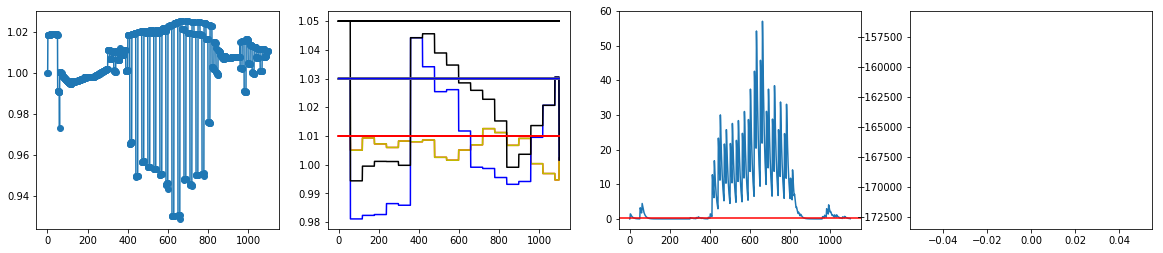

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 1.1416597366333008 seconds ---
--- 0.05348944664001465 seconds ---
--- 0.06843233108520508 seconds ---
--- 0.05398392677307129 seconds ---
--- 0.06454586982727051 seconds ---
--- 0.06475520133972168 seconds ---
--- 0.06258773803710938 seconds ---
-157690.9397586485
--- 71.03193283081055 seconds ---


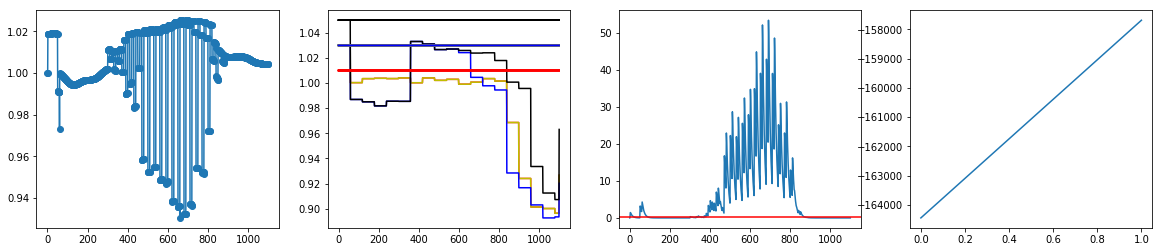

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06223630905151367 seconds ---
--- 0.06029772758483887 seconds ---
--- 0.06520724296569824 seconds ---
--- 0.06472325325012207 seconds ---
--- 0.06107306480407715 seconds ---
--- 0.06501960754394531 seconds ---
--- 0.06267499923706055 seconds ---
--- 0.049825429916381836 seconds ---
--- 0.0528264045715332 seconds ---
--- 0.05382537841796875 seconds ---
--- 0.05859565734863281 seconds ---
--- 0.07342362403869629 seconds ---
--- 0.06000995635986328 seconds ---
--- 0.06472897529602051 seconds ---
--- 0.06267523765563965 seconds ---
--- 0.0740213394165039 seconds ---
--- 0.059362173080444336 seconds ---
--- 0.06151556968688965 seconds ---
--- 0.06466317176818848 seconds ---
-1314.2881846358289
--- 81.93641757965088 seconds ---


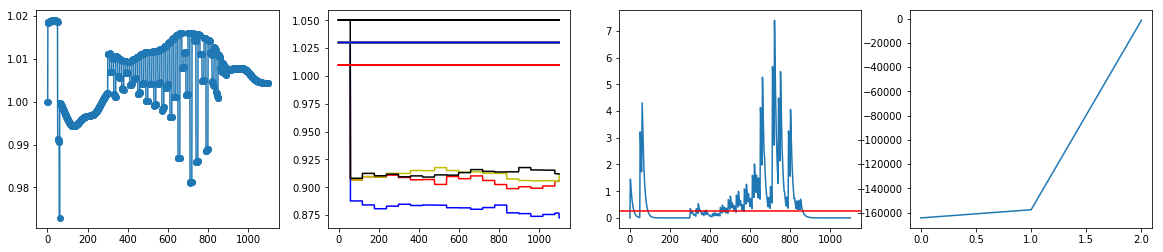

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06306719779968262 seconds ---
--- 0.05786609649658203 seconds ---
--- 0.05487871170043945 seconds ---
--- 0.06049370765686035 seconds ---
--- 0.054380178451538086 seconds ---
--- 0.05676078796386719 seconds ---
--- 0.06050300598144531 seconds ---
--- 0.05604290962219238 seconds ---
--- 0.07020950317382812 seconds ---
--- 0.052692413330078125 seconds ---
--- 0.06606721878051758 seconds ---
--- 0.07602167129516602 seconds ---
--- 0.06078743934631348 seconds ---
--- 0.07051515579223633 seconds ---
--- 0.06059908866882324 seconds ---
--- 0.05425429344177246 seconds ---
--- 0.06962943077087402 seconds ---
--- 0.062591552734375 seconds ---
--- 0.06860733032226562 seconds ---
-1314.2881846358289
--- 80.44993948936462 seconds ---


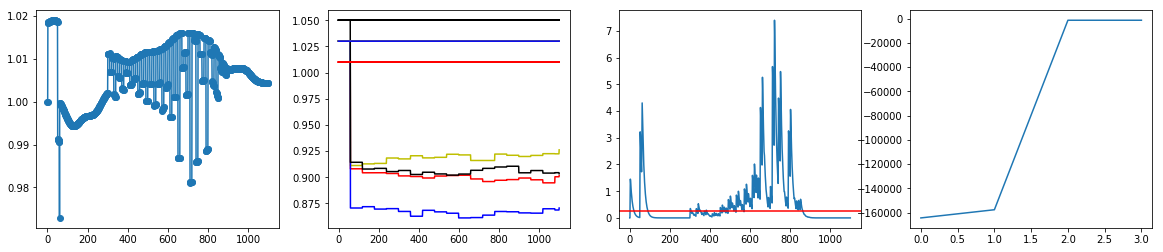

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06830739974975586 seconds ---
--- 0.05434393882751465 seconds ---
--- 0.051084280014038086 seconds ---
--- 0.059212684631347656 seconds ---
--- 0.05753684043884277 seconds ---
--- 0.06757688522338867 seconds ---
--- 0.06227993965148926 seconds ---
--- 0.03595376014709473 seconds ---
--- 0.059396982192993164 seconds ---
--- 0.05978584289550781 seconds ---
--- 0.0643923282623291 seconds ---
--- 0.0646371841430664 seconds ---
--- 0.058593034744262695 seconds ---
--- 0.07173848152160645 seconds ---
--- 0.07153940200805664 seconds ---
--- 0.06923127174377441 seconds ---
--- 0.0473940372467041 seconds ---
--- 0.06384015083312988 seconds ---
--- 0.06598138809204102 seconds ---
-1314.2881846358289
--- 84.71911692619324 seconds ---


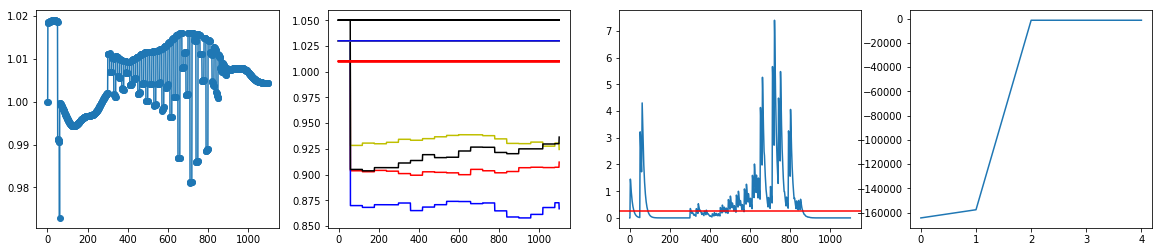

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06522989273071289 seconds ---
--- 0.05917787551879883 seconds ---
--- 0.061270713806152344 seconds ---
--- 0.05513763427734375 seconds ---
--- 0.0721290111541748 seconds ---
--- 0.06154775619506836 seconds ---
--- 0.061727046966552734 seconds ---
--- 0.060996294021606445 seconds ---
--- 0.058928489685058594 seconds ---
--- 0.05924630165100098 seconds ---
--- 0.06806683540344238 seconds ---
--- 0.08032679557800293 seconds ---
--- 0.06309056282043457 seconds ---
--- 0.0570836067199707 seconds ---
--- 0.06604623794555664 seconds ---
--- 0.05964541435241699 seconds ---
--- 0.06491851806640625 seconds ---
--- 0.0645287036895752 seconds ---
--- 0.0660543441772461 seconds ---
-1314.2881846358289
--- 81.21191334724426 seconds ---


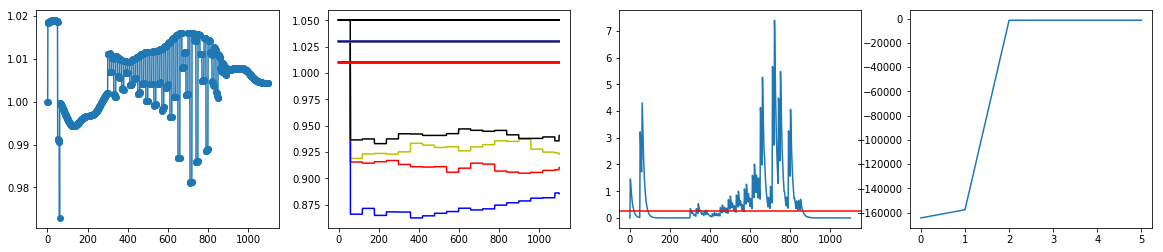

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.056284427642822266 seconds ---
--- 0.06106686592102051 seconds ---
--- 0.06622672080993652 seconds ---
--- 0.0583500862121582 seconds ---
--- 0.06408214569091797 seconds ---
--- 0.056398868560791016 seconds ---
--- 0.06229066848754883 seconds ---
--- 0.05990743637084961 seconds ---
--- 0.05879926681518555 seconds ---
--- 0.05403256416320801 seconds ---
--- 0.05146646499633789 seconds ---
--- 0.06018781661987305 seconds ---
--- 0.056299448013305664 seconds ---
--- 0.06746983528137207 seconds ---
--- 0.05560731887817383 seconds ---
--- 0.0673990249633789 seconds ---
--- 0.06615877151489258 seconds ---
--- 0.05824732780456543 seconds ---
--- 0.06847500801086426 seconds ---
-1314.2881846358289
--- 80.74256372451782 seconds ---


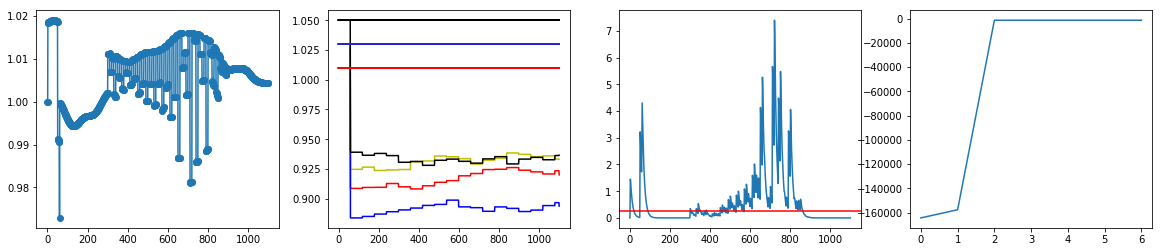

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06382203102111816 seconds ---
--- 0.057892799377441406 seconds ---
--- 0.0388944149017334 seconds ---
--- 0.030918121337890625 seconds ---
--- 0.032909393310546875 seconds ---
--- 0.03091597557067871 seconds ---
--- 0.030916452407836914 seconds ---
--- 0.03889584541320801 seconds ---
--- 0.04283261299133301 seconds ---
--- 0.033907175064086914 seconds ---
--- 0.040250301361083984 seconds ---
--- 0.028677940368652344 seconds ---
--- 0.03019571304321289 seconds ---
--- 0.030916452407836914 seconds ---
--- 0.03019118309020996 seconds ---
--- 0.030188798904418945 seconds ---
--- 0.04031014442443848 seconds ---
--- 0.030216455459594727 seconds ---
--- 0.03191351890563965 seconds ---
-1314.2881846358289
--- 66.70795321464539 seconds ---


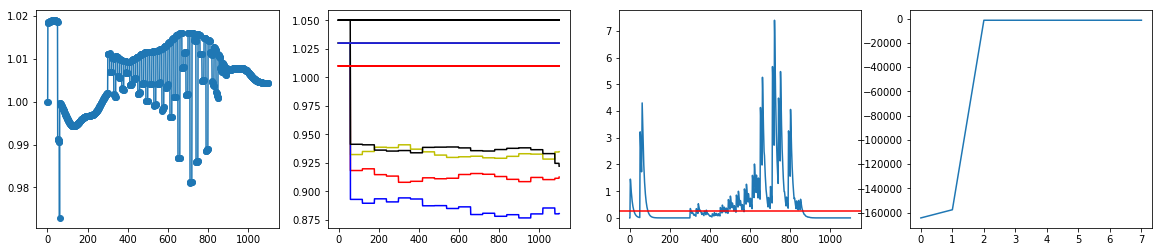

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.03789877891540527 seconds ---
--- 0.030185222625732422 seconds ---
--- 0.031912803649902344 seconds ---
--- 0.03291034698486328 seconds ---
--- 0.03821992874145508 seconds ---
--- 0.03291153907775879 seconds ---
--- 0.034905195236206055 seconds ---
--- 0.030205488204956055 seconds ---
--- 0.040277719497680664 seconds ---
--- 0.031912803649902344 seconds ---
--- 0.03889656066894531 seconds ---
--- 0.030916929244995117 seconds ---
--- 0.031914472579956055 seconds ---
--- 0.03291130065917969 seconds ---
--- 0.036890268325805664 seconds ---
--- 0.030916929244995117 seconds ---
--- 0.03091597557067871 seconds ---
--- 0.034270524978637695 seconds ---
--- 0.030216455459594727 seconds ---
-1314.2881846358289
--- 59.174884557724 seconds ---


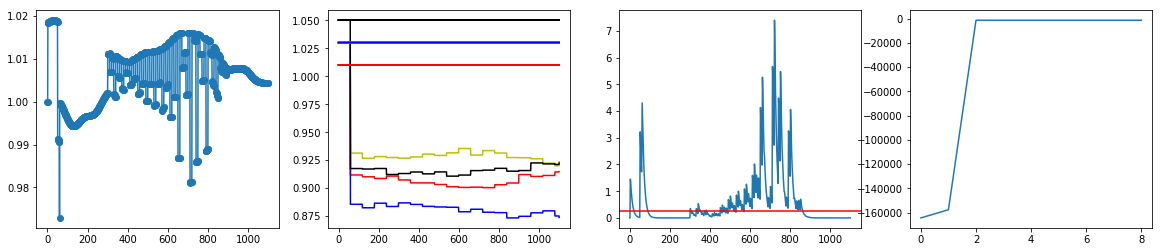

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.031912803649902344 seconds ---
--- 0.029918670654296875 seconds ---
--- 0.03017282485961914 seconds ---
--- 0.04027867317199707 seconds ---
--- 0.03390932083129883 seconds ---
--- 0.034180402755737305 seconds ---
--- 0.03091287612915039 seconds ---
--- 0.030205488204956055 seconds ---
--- 0.03191423416137695 seconds ---
--- 0.035901784896850586 seconds ---
--- 0.03018951416015625 seconds ---
--- 0.031913042068481445 seconds ---
--- 0.030917644500732422 seconds ---
--- 0.03390812873840332 seconds ---
--- 0.03191423416137695 seconds ---
--- 0.03690052032470703 seconds ---
--- 0.03191351890563965 seconds ---
--- 0.030916452407836914 seconds ---
--- 0.030167818069458008 seconds ---
-1314.2881846358289
--- 60.476675510406494 seconds ---


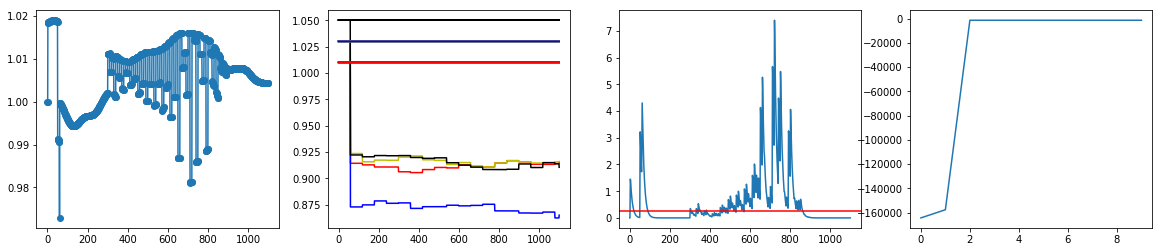

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.032912254333496094 seconds ---
--- 0.030916213989257812 seconds ---
--- 0.03191423416137695 seconds ---
--- 0.03690004348754883 seconds ---
--- 0.03291177749633789 seconds ---
--- 0.034905433654785156 seconds ---
--- 0.03019404411315918 seconds ---
--- 0.03390812873840332 seconds ---
--- 0.03291153907775879 seconds ---
--- 0.030915498733520508 seconds ---
--- 0.030181884765625 seconds ---
--- 0.030173063278198242 seconds ---
--- 0.030914783477783203 seconds ---
--- 0.030202865600585938 seconds ---
--- 0.04029440879821777 seconds ---
--- 0.03128361701965332 seconds ---
--- 0.030915498733520508 seconds ---
--- 0.029919862747192383 seconds ---
--- 0.030206680297851562 seconds ---
-1314.2881846358289
--- 58.805591344833374 seconds ---


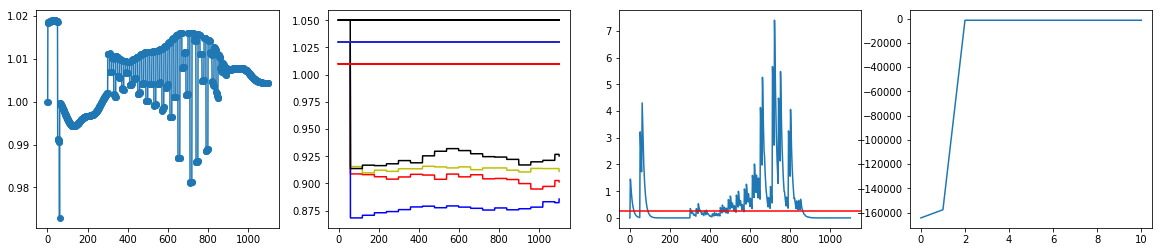

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.038895368576049805 seconds ---
--- 0.038248538970947266 seconds ---
--- 0.030915498733520508 seconds ---
--- 0.030916452407836914 seconds ---
--- 0.031914710998535156 seconds ---
--- 0.031914472579956055 seconds ---
--- 0.032910823822021484 seconds ---
--- 0.03091716766357422 seconds ---
--- 0.06581830978393555 seconds ---
--- 0.030917644500732422 seconds ---
--- 0.03291177749633789 seconds ---
--- 0.03291010856628418 seconds ---
--- 0.03391098976135254 seconds ---
--- 0.03291058540344238 seconds ---
--- 0.03191423416137695 seconds ---
--- 0.03091573715209961 seconds ---
--- 0.03191423416137695 seconds ---
--- 0.030188798904418945 seconds ---
--- 0.030758380889892578 seconds ---
-1314.2881846358289
--- 67.22296738624573 seconds ---


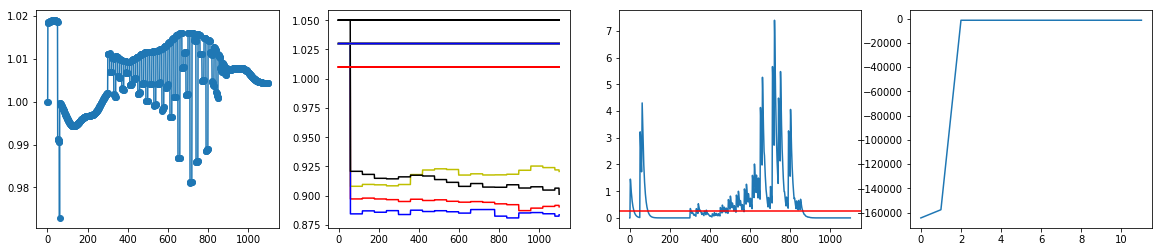

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.03789639472961426 seconds ---
--- 0.03220844268798828 seconds ---
--- 0.030915260314941406 seconds ---
--- 0.03827190399169922 seconds ---
--- 0.03390908241271973 seconds ---
--- 0.04027700424194336 seconds ---
--- 0.030915260314941406 seconds ---
--- 0.03020167350769043 seconds ---
--- 0.03091716766357422 seconds ---
--- 0.0301969051361084 seconds ---
--- 0.03191518783569336 seconds ---
--- 0.030917882919311523 seconds ---
--- 0.03290915489196777 seconds ---
--- 0.030916452407836914 seconds ---
--- 0.034906625747680664 seconds ---
--- 0.03018331527709961 seconds ---
--- 0.03827500343322754 seconds ---
--- 0.031915903091430664 seconds ---
--- 0.030217647552490234 seconds ---
-1314.2881846358289
--- 59.35896182060242 seconds ---


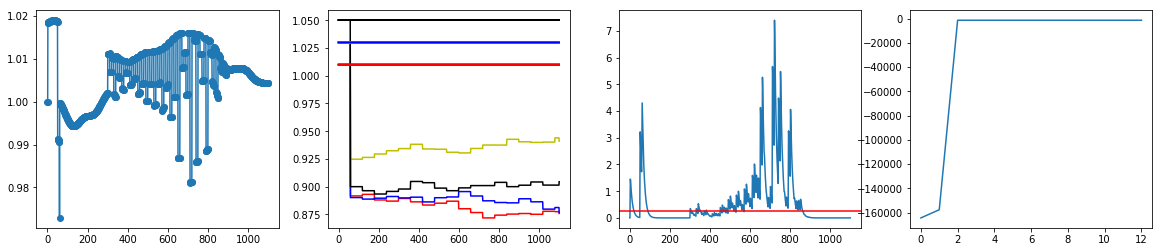

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.040273189544677734 seconds ---
--- 0.030915260314941406 seconds ---
--- 0.029919862747192383 seconds ---
--- 0.03822922706604004 seconds ---
--- 0.03789806365966797 seconds ---
--- 0.030174732208251953 seconds ---
--- 0.03820466995239258 seconds ---
--- 0.03191494941711426 seconds ---
--- 0.03022909164428711 seconds ---
--- 0.03017735481262207 seconds ---
--- 0.031912803649902344 seconds ---
--- 0.040889739990234375 seconds ---
--- 0.03789830207824707 seconds ---
--- 0.030917644500732422 seconds ---
--- 0.031914710998535156 seconds ---
--- 0.03290963172912598 seconds ---
--- 0.048310041427612305 seconds ---
--- 0.030182361602783203 seconds ---
--- 0.030199289321899414 seconds ---
-1314.2881846358289
--- 62.10100507736206 seconds ---


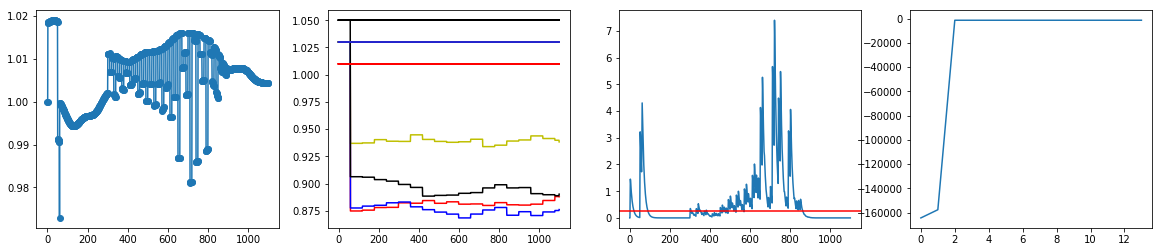

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.03191375732421875 seconds ---
--- 0.03291153907775879 seconds ---
--- 0.03789687156677246 seconds ---
--- 0.030914783477783203 seconds ---
--- 0.030916452407836914 seconds ---
--- 0.03191256523132324 seconds ---
--- 0.03191399574279785 seconds ---
--- 0.030916929244995117 seconds ---
--- 0.032911062240600586 seconds ---
--- 0.035906076431274414 seconds ---
--- 0.03989267349243164 seconds ---
--- 0.031914710998535156 seconds ---
--- 0.03091597557067871 seconds ---
--- 0.03589653968811035 seconds ---
--- 0.030916690826416016 seconds ---
--- 0.03091716766357422 seconds ---
--- 0.03091740608215332 seconds ---
--- 0.03191518783569336 seconds ---
--- 0.030918598175048828 seconds ---
-1314.2881846358289
--- 68.61117434501648 seconds ---


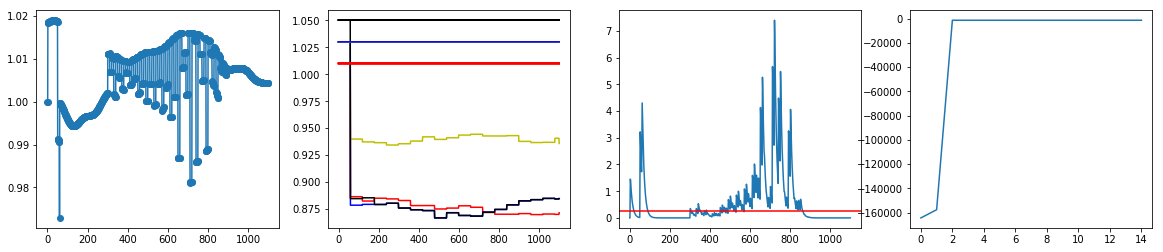

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.03191423416137695 seconds ---
--- 0.033908843994140625 seconds ---
--- 0.03789806365966797 seconds ---
--- 0.030915260314941406 seconds ---
--- 0.03291130065917969 seconds ---
--- 0.035901784896850586 seconds ---
--- 0.03291177749633789 seconds ---
--- 0.03091597557067871 seconds ---
--- 0.03191399574279785 seconds ---
--- 0.03191423416137695 seconds ---
--- 0.034905433654785156 seconds ---
--- 0.03390836715698242 seconds ---
--- 0.0379033088684082 seconds ---
--- 0.03091716766357422 seconds ---
--- 0.030916690826416016 seconds ---
--- 0.03290963172912598 seconds ---
--- 0.03989148139953613 seconds ---
--- 0.036901235580444336 seconds ---
--- 0.032910823822021484 seconds ---
-1314.2881846358289
--- 76.02456974983215 seconds ---


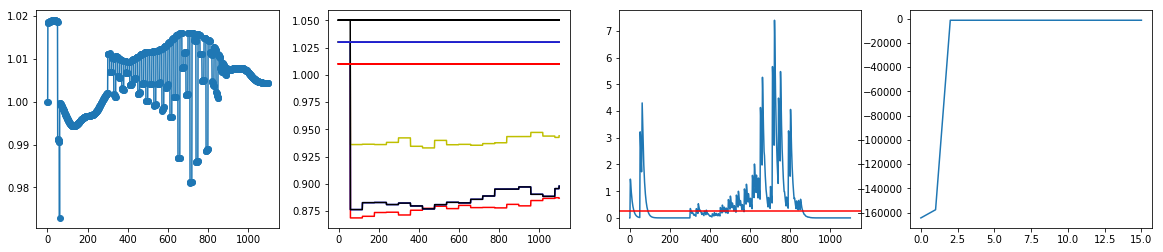

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.03390765190124512 seconds ---
--- 0.032904863357543945 seconds ---
--- 0.03789830207824707 seconds ---
--- 0.03291034698486328 seconds ---
--- 0.030914306640625 seconds ---
--- 0.030213117599487305 seconds ---
--- 0.030191659927368164 seconds ---
--- 0.030192852020263672 seconds ---
--- 0.03391003608703613 seconds ---
--- 0.03191423416137695 seconds ---
--- 0.03490710258483887 seconds ---
--- 0.03824424743652344 seconds ---
--- 0.030172109603881836 seconds ---
--- 0.03827714920043945 seconds ---
--- 0.03191328048706055 seconds ---
--- 0.030916452407836914 seconds ---
--- 0.03291153907775879 seconds ---
--- 0.03390860557556152 seconds ---
--- 0.03390932083129883 seconds ---
-1314.2881846358289
--- 62.78884434700012 seconds ---


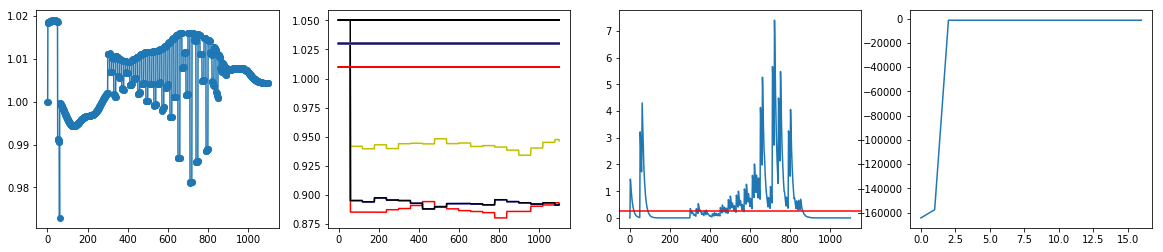

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.03290987014770508 seconds ---
--- 0.03789377212524414 seconds ---
--- 0.0329127311706543 seconds ---
--- 0.03290987014770508 seconds ---
--- 0.03170061111450195 seconds ---
--- 0.03390812873840332 seconds ---
--- 0.03017401695251465 seconds ---
--- 0.03019857406616211 seconds ---
--- 0.031914710998535156 seconds ---
--- 0.030201196670532227 seconds ---
--- 0.038202762603759766 seconds ---
--- 0.03061056137084961 seconds ---
--- 0.031913042068481445 seconds ---
--- 0.03590798377990723 seconds ---
--- 0.03191328048706055 seconds ---
--- 0.031915903091430664 seconds ---
--- 0.03191375732421875 seconds ---
--- 0.03191375732421875 seconds ---
--- 0.03191375732421875 seconds ---
-1314.2881846358289
--- 62.3553307056427 seconds ---


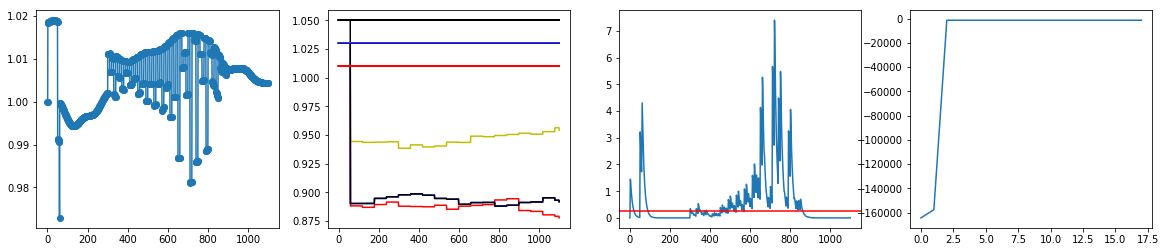

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.03291010856628418 seconds ---
--- 0.032911062240600586 seconds ---
--- 0.03490424156188965 seconds ---
--- 0.030916690826416016 seconds ---
--- 0.032911062240600586 seconds ---
--- 0.029918909072875977 seconds ---
--- 0.029918670654296875 seconds ---
--- 0.03291153907775879 seconds ---
--- 0.03690004348754883 seconds ---
--- 0.03020954132080078 seconds ---
--- 0.036901235580444336 seconds ---
--- 0.030916213989257812 seconds ---
--- 0.035902976989746094 seconds ---
--- 0.03191232681274414 seconds ---
--- 0.030919313430786133 seconds ---
--- 0.039891958236694336 seconds ---
--- 0.034905433654785156 seconds ---
--- 0.04487776756286621 seconds ---
--- 0.032912492752075195 seconds ---
-1314.2881846358289
--- 68.09423637390137 seconds ---


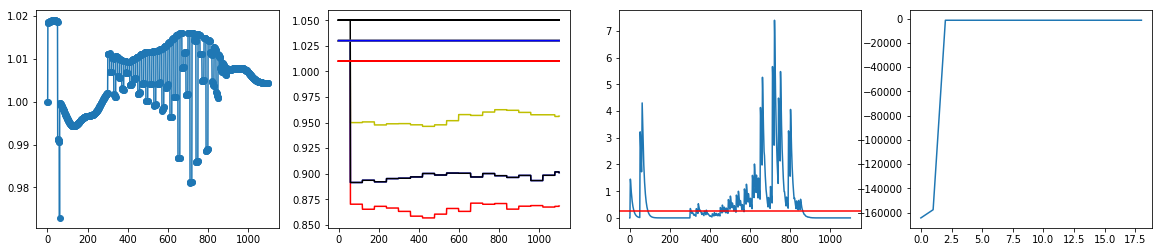

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.03091716766357422 seconds ---
--- 0.034905433654785156 seconds ---
--- 0.03989291191101074 seconds ---
--- 0.03191375732421875 seconds ---
--- 0.03091287612915039 seconds ---
--- 0.030917644500732422 seconds ---
--- 0.03191351890563965 seconds ---
--- 0.030912160873413086 seconds ---
--- 0.04089021682739258 seconds ---
--- 0.03291058540344238 seconds ---
--- 0.04787158966064453 seconds ---
--- 0.03291177749633789 seconds ---
--- 0.030916929244995117 seconds ---
--- 0.035902976989746094 seconds ---
--- 0.03590130805969238 seconds ---
--- 0.030916690826416016 seconds ---
--- 0.02991938591003418 seconds ---
--- 0.03191423416137695 seconds ---
--- 0.04088902473449707 seconds ---
-1314.2881846358289
--- 68.59003019332886 seconds ---


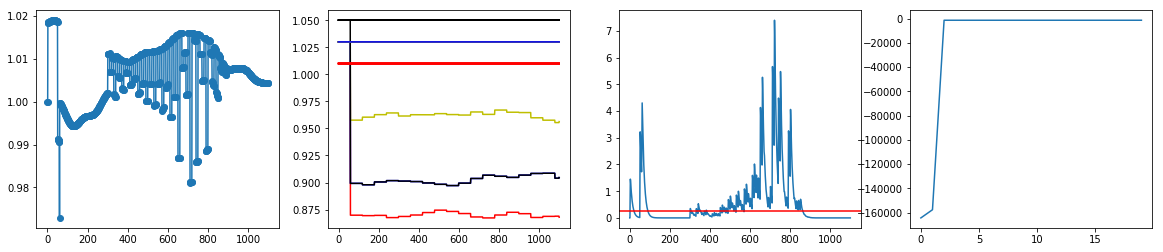

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.03590226173400879 seconds ---
--- 0.03291177749633789 seconds ---
--- 0.029918193817138672 seconds ---
--- 0.03291201591491699 seconds ---
--- 0.03690075874328613 seconds ---
--- 0.030916452407836914 seconds ---
--- 0.04188847541809082 seconds ---
--- 0.030916213989257812 seconds ---
--- 0.03490567207336426 seconds ---
--- 0.03490638732910156 seconds ---
--- 0.03191375732421875 seconds ---
--- 0.04288434982299805 seconds ---
--- 0.03390955924987793 seconds ---
--- 0.03091716766357422 seconds ---
--- 0.03390908241271973 seconds ---
--- 0.03789830207824707 seconds ---
--- 0.04188728332519531 seconds ---
--- 0.031914710998535156 seconds ---
--- 0.032912254333496094 seconds ---
-1314.2881846358289
--- 70.74743723869324 seconds ---


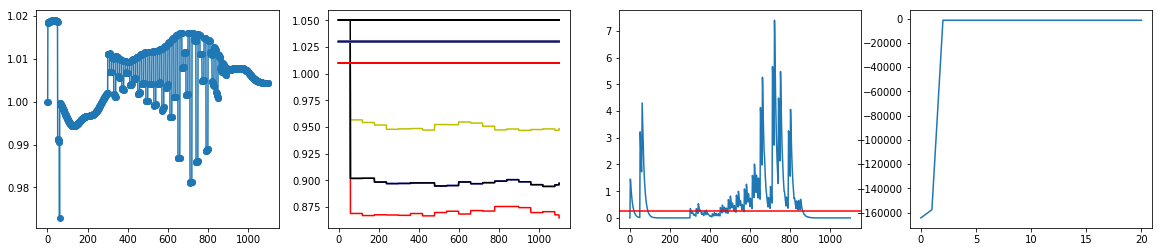

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.03291177749633789 seconds ---
--- 0.0359041690826416 seconds ---
--- 0.0388941764831543 seconds ---
--- 0.03291130065917969 seconds ---
--- 0.03191375732421875 seconds ---
--- 0.03789806365966797 seconds ---
--- 0.034906864166259766 seconds ---
--- 0.03191518783569336 seconds ---
--- 0.03390908241271973 seconds ---
--- 0.030916929244995117 seconds ---


In [ ]:
totalPoints = [[],[],[],[],[],[],[],[],[],[],[],[],[]]
############################################
########### INIT FOR AGENT #################
############################################

#init action
oldAction = []
action = []

#init state
oldState = []
state = []

#init reward
reward = None

mb_state=[]
mb_action=[]
mb_reward=[]
mb_nextstate=[]
buffer = ReplayBuffer(300)
BATCH_SIZE = 30

noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(4), sigma=0.3, theta=.1, dt=1e-2)
epsilon = 1
EXPLORE = 144100

for ep in range(50):
    Load = Origin_Load.copy()
    Generation = Origin_Generation.copy()
    #this is for permutate the Load and Generation profile on each node
    #Load = np.random.permutation(Load.T).T
    #Generation = np.random.permutation(Generation.T).T

    #this is to permutate the Load and Generation profile
    #temp = np.copy(Load[:, 0:Number_of_Inverters])
    #Load[:, 0:Number_of_Inverters] = Load[:, Number_of_Inverters:Number_of_Inverters*2]
    #Load[:, Number_of_Inverters:Number_of_Inverters*2] = temp
    #temp = np.copy(Generation[:, 0:Number_of_Inverters])
    #Generation[:, 0:Number_of_Inverters] = Generation[:, Number_of_Inverters:Number_of_Inverters*2]
    #Generation[:, Number_of_Inverters:Number_of_Inverters*2] = temp

    #Create noise vector
    Noise = np.empty([TotalTimeSteps, TotalLoads])
    for node in range(TotalLoads):
        Noise[:,node] = np.random.randn(TotalTimeSteps) 

    #Add noise to loads
    for node in range(TotalLoads):
        Load[:,node] = Load[:,node] + NoiseMultiplyer*Noise[:,node]

    if NoiseMultiplyer > 0:
        print('Load Interpolation has been done. Noise was added to the load profile.') 
    else:
        print('Load Interpolation has been done. No Noise was added to the load profile.') 

    MaxGenerationPossible = np.max(Generation, axis = 0)
    sbar = MaxGenerationPossible
    
    start_time = time.time()
    #########################################################
    ################### RESTART OPENDSS #####################
    #########################################################
    DSSStart = DSSStartup()
    DSSText =DSSStart['dsstext']
    DSSSolution = DSSStart['dsssolution']
    DSSCircuit = DSSStart['dsscircuit']
    DSSObj = DSSStart['dssobj']
    DSSMon = DSSCircuit.Monitors
    DSSText.command = 'Compile C:\\feeders\\feeder34_B_NR\\feeder34_B_NR.dss'
    DSSSolution.Solve()
    if not DSSSolution.Converged:
        print('Initial Solution Not Converged. Check Model for Convergence')
    else:
        print('Initial Model Converged. Proceeding to Next Step.')
        #Doing this solve command is required for GridPV, that is why the monitors
        #go under a reset process
        DSSMon.ResetAll
        setSolutionParams(DSSObj,'daily',1,1,'off',1000000,30000)
        #Easy process to get all names and count of loads, a trick to avoid
        #some more lines of code
        TotalLoads=DSSCircuit.Loads.Count
        AllLoadNames=DSSCircuit.Loads.AllNames
        print('OpenDSS Model Compliation Done.')

    ############################################
    ############ INIT NODES ####################
    ############################################
    nodes = {}
    features = ['Voltage', 'Generation', 'P', 'Q']

    for i in range(len(AllLoadNames)):
        df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
        nodes[i] = df
        nodes[i].loc['Generation'] = Generation[:,i]
        nodes[i].loc['P'] = 0
        nodes[i].loc['Q'] = 0

    ################################################
    ############ INIT INVERTERS ####################
    ################################################
    inverters = {}
    features = ['VBP', 'FilterVoltage', 'Generation', 'sbar', 'P_inv', 'Q_inv' ,'counter', 'ime_output', 'ep_output', 'yk', 'upk','uqk']

    offset = 5
    numberofInverters = Number_of_Inverters

    for i in range(len(AllLoadNames)):
        inverters[i] = []
        if offset-1 < i < numberofInverters + offset:
            df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
            df.at['FilterVoltage', 0] = 0
            df.loc['Generation'] = Generation[:,i]
            df.loc['sbar'] = sbar[i]
            df.loc['counter'] = 0
            df.loc['ime_output'] = 0
            df.loc['ep_output'] = 0
            df.loc['yk'] = 0
            df.loc['P_inv'] = 0
            df.loc['Q_inv'] = 0
            df.loc['upk'] = 0
            df.loc['uqk'] = 0
            inverters[i].append(df)

    ############################################
    ########### INIT VBPCURVE ##################
    ############################################
    for i in range(len(AllLoadNames)):
        for j in range(len(inverters[i])):
            for k in range(TotalTimeSteps):
                inverters[i][j].at['VBP',k] = np.array([1.01, 1.03, 1.03, 1.05])

    VBPcounter = [0,0,0,0,0,0,0,0,0,0,0,0,0]

    controlInv = list(range(7,8))    
    points = [0,0,0,0,0,0,0,0,0,0,0,0,0]
    terminal = False
    
    for timeStep in range(TotalTimeSteps):
        epsilon -= 1/EXPLORE
        
        VBPcounter = [x+1 for x in VBPcounter] 
        ####################################################
        ################ run the simulation ################
        ####################################################
        #for the first steps, we just init voltage value, no pq injection
        if timeStep == 0:
            for node in range(len(AllLoadNames)):
                nodeName = AllLoadNames[node]
                setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node]])
                setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node]])
        else:
            for node in range(len(AllLoadNames)):
                nodeName = AllLoadNames[node]
                setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node] + nodes[node].at['P', timeStep-1]])
                setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node] + nodes[node].at['Q', timeStep-1]])

        DSSSolution.Solve()
        if (not DSSSolution.Converged):
            print('Solution Not Converged at Step:', timeStep)

        #get the voltage info
        nodeInfo = getLoadInfo(DSSObj, [])
        #distribute voltage to node
        for i in range(len(nodes)):
            node = nodes[i]
            node.at['Voltage', timeStep] = nodeInfo[i]['voltagePU']
            if timeStep == 0 or timeStep == 1:
                node.at['Voltage', timeStep] = 1
        #############################################################
        #############################################################
        #############################################################
        if timeStep == TimeStepOfHack:
            for node in range(len(AllLoadNames)):
                if inverters[node] != []:
                    inverter = inverters[node][0]
                    #create new inverter
                    hackedInv = copy.deepcopy(inverter)
                    for k in range(timeStep, TotalTimeSteps):
                        hackedInv.at['VBP',k] = np.array([1.01, 1.015, 1.015, 1.02])

                    hackedInv.loc['sbar'][timeStep:] = hackedInv.loc['sbar'][timeStep:]*PercentHacked[node]
                    hackedInv.loc['Generation'][timeStep:] = hackedInv.loc['Generation'][timeStep:]*PercentHacked[node]
                    inverters[node].append(hackedInv)
                    #generation and sbar change on the original inverter
                    inverter.loc['sbar'][timeStep:] = inverter.loc['sbar'][timeStep:]*(1-PercentHacked[node])
                    inverter.loc['Generation'][timeStep:] = inverter.loc['Generation'][timeStep:]*(1-PercentHacked[node])
        ########################################################################
        ########################################################################
        ########################################################################
        
        if timeStep == TotalTimeSteps-1:
            terminal = True
            
        if timeStep != 0:
            for node in range(len(AllLoadNames)):
                #if we have inverters at that node then...
                if inverters[node] != []:
                    invertersNode = inverters[node] #get the list of inverters at that node
                    for inverter in invertersNode: #get an inverter at that node
                        #increase the counter
                        inverter.at['counter',timeStep] = inverter.at['counter',timeStep-1] + 1
                        if inverter.at['counter',timeStep-1] == Delay_VoltageSampling[node]:
                            inverter.at['counter',timeStep] = 1
                            
                        #get State
                        if (node in controlInv) and (inverter is invertersNode[0]):
                            if VBPcounter[node-offset] == Delay_VBPCurveShift[node] or terminal == True:
                                if terminal == False:
                                    length = Delay_VBPCurveShift[node]
                                    V = nodes[node].loc['Voltage',timeStep-length+1:timeStep]
                                    G = inverter.loc['Generation', timeStep-length+1:timeStep] 
                                    L = Load[timeStep-length+1:timeStep+1, node]
                                else:
                                    length = VBPcounter[node-offset]
                                    V = nodes[node].loc['Voltage',timeStep-length+1:]
                                    G = inverter.loc['Generation', timeStep-length+1:]
                                    L = Load[timeStep-length+1:, node]
                                    
                                oldState = state
                                state = processing_state(V,G,L)
                                #reset VBPcounter
                                VBPcounter[node-offset] = 0
                                #store action                        
                                oldAction = copy.deepcopy(action)
                                
                                #get Action from Agent
                                action = agent.action_respond(state.reshape((1,60,3)))
                                action += noise() * max(epsilon, 0)
                                #apply strict boundary
                                if action[1] < action[0]:
                                    action[0] = action[1]
                                if action[3] < action[2]:
                                    action[2] = action[3]
                                for k in range(timeStep, TotalTimeSteps):
                                    inverter.at['VBP',k] = copy.deepcopy(action*0.1 + 1)
                                
                                #reward
                                #caculate yk for that inverter
                                inverter.at['yk', timeStep], inverter.at['ime_output', timeStep], inverter.at['ep_output', timeStep] = voltage_observer(
                                         nodes[node].at['Voltage', timeStep], 
                                         nodes[node].at['Voltage', timeStep-1],
                                         inverter.at['ime_output', timeStep-1], 
                                         inverter.at['ep_output', timeStep-1], 
                                         inverter.at['yk', timeStep-1])

                                numberYks = inverter.loc['yk', timeStep-length+1:timeStep]
                                numberYks = numberYks - 0.25
                                numberYks = numberYks[numberYks > 0]
                                reward = - sum(numberYks**2)
                                
                                #sum of reward for that ep
                                points[node-offset] += reward
                                
                                
                                if oldAction != [] and oldState != []:
                                    if terminal: 
                                        ter = 1
                                    else:
                                        ter = 0
                                    buffer.add(oldState.reshape((60,3)), oldAction, np.array([reward]), np.array([ter]), state.reshape((60,3)))
                                
                                if buffer.size() > BATCH_SIZE:
                                    batch = {}
                                    mb_state, mb_action, mb_reward, mb_ter, mb_nextstate = buffer.sample_batch(BATCH_SIZE)
                                    batch['observations'] = mb_state
                                    batch['actions'] = mb_action
                                    batch['rewards'] = mb_reward
                                    batch['next_observations'] = mb_nextstate
                                    batch['rewards'] = mb_reward
                                    batch['terminals'] = mb_ter
                                    start_time_train = time.time()
                                    agent.do_training(batch)
                                    print("--- %s seconds ---" % (time.time() - start_time_train))
                        #################################################                        
                        #################################################
                        #execute action
                        inverter.at['Q_inv', timeStep], inverter.at['P_inv', timeStep], inverter.at['FilterVoltage', timeStep] = inverter_qp_injection(
                            inverter.at['counter',timeStep],
                            nodes[node].at['Voltage', timeStep],
                            nodes[node].at['Voltage', timeStep-1],
                            inverter.at['FilterVoltage', timeStep-1],
                            inverter.at['Generation', timeStep],
                            inverter.at['VBP', timeStep],
                            inverter.at['sbar', timeStep],
                            Delay_VoltageSampling[node])
                        
                        inverter.at['yk', timeStep], inverter.at['ime_output', timeStep], inverter.at['ep_output', timeStep] = voltage_observer(
                                         nodes[node].at['Voltage', timeStep], 
                                         nodes[node].at['Voltage', timeStep-1],
                                         inverter.at['ime_output', timeStep-1], 
                                         inverter.at['ep_output', timeStep-1], 
                                         inverter.at['yk', timeStep-1])

                        
                        
                        #caculate P Q injection at the node
                        nodes[node].at['P', timeStep] += inverter.at['P_inv', timeStep]
                        nodes[node].at['Q', timeStep] += inverter.at['Q_inv', timeStep]

    ######### drawing #####################
    
    for i in range(len(points)):
        totalPoints[i].append(points[i])
    print(max(totalPoints[7-offset]))
    print("--- %s seconds ---" % (time.time() - start_time))
    f = plt.figure()
    f.set_figheight(4)
    f.set_figwidth(20)
    f.add_subplot(1,4,1)
    plt.plot(nodes[7].loc['Voltage'], marker='o')
    
    for i in range(5,18):
        x = inverters[i][0].loc['VBP']
        y=np.zeros([len(x),x[0].shape[0]])
        for i in range(len(x)):
            y[i,:] = x[i]
        f.add_subplot(1,4,2)
        plt.plot(y[:,0], 'r')
        plt.plot(y[:,1], 'y')
        plt.plot(y[:,2], 'b')
        plt.plot(y[:,3], 'k')
    
    f.add_subplot(1,4,3)
    for i in range(7,8):
        yk = inverters[i][0].loc['yk']
        plt.plot(yk)
    plt.axhline(y=0.25, color='r', linestyle='-')
    f.add_subplot(1,4,4)
    plt.plot(totalPoints[7-offset])
    plt.show(block=True)
    f.savefig(str(ep) + '.png')


In [ ]:
noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(4), sigma=0.3, theta=.1, dt=1e-2)

In [ ]:
noiseList = []
for i in range(1000):
    noiseList.append(noise())
    
plt.plot(noiseList)